In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from os.path import join
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
from scipy.stats import pearsonr
from IPython.display import display
from skopt.plots import plot_objective
import seaborn as sns
from time import time
import skopt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import xgboost as xgb

rng_seed = 399
np.random.seed(rng_seed)
import persim
import joblib

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    f1_score,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.linear_model import Lasso, LassoCV, LogisticRegressionCV
from sklearn.preprocessing import minmax_scale, RobustScaler

import tensorflow as tf

try:
    # Disable all GPUS
    tf.config.set_visible_devices([], "GPU")
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != "GPU"
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

from tensorflow.keras.activations import relu
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Directory constants
root_code_dir = ".."
output_dir = join(root_code_dir, "output")
word2vec_training_dir = join(output_dir, "word2vec_training")
word2vec_ann_indices_dir = join(output_dir, "word2vec_ann_indices")
word2vec_cluster_analysis_dir = join(output_dir, "word2vec_cluster_analysis")

# Extend sys path for importing custom Python files
import sys

sys.path.append(root_code_dir)

from topological_data_analysis.topological_polysemy import tps
from word_embeddings.word2vec import load_model_training_output
from analysis_of_embeddings.estimate_num_meanings_supervised import (
    create_classification_labels,
    evaluate_regression_model,
    evaluate_classification_model,
    create_feature_importance_df,
    visualize_feature_importances,
)

<IPython.core.display.Javascript object>

## Prepare data

In [3]:
word_meaning_train_data = pd.read_csv("data/word_meaning_train_data.csv")
word_meaning_test_data = pd.read_csv("data/word_meaning_test_data.csv")
word_meaning_semeval_test_data = pd.read_csv("data/word_meaning_semeval_test_data.csv")
word_meaning_data_cols = word_meaning_train_data.columns.values
word_meaning_data_feature_cols = np.array(
    [col for col in word_meaning_data_cols if col.startswith("X_")]
)

<IPython.core.display.Javascript object>

In [4]:
print("Train")
word_meaning_train_data

Train


,word,y,X_tps_10,X_tps_10_pd_max,X_tps_10_pd_avg,X_tps_10_pd_std,X_tps_20,X_tps_20_pd_max,X_tps_20_pd_avg,X_tps_20_pd_std,...,X_gad_knn_200_1250_P_int,X_gad_knn_200_1500_P_bnd,X_gad_knn_200_1500_P_man,X_gad_knn_200_1500_P_int,X_gad_knn_200_1750_P_bnd,X_gad_knn_200_1750_P_man,X_gad_knn_200_1750_P_int,X_gad_knn_200_2000_P_bnd,X_gad_knn_200_2000_P_man,X_gad_knn_200_2000_P_int
0,wheatgrass,1,3.338852,0.905638,0.741967,0.081652,6.572863,0.905638,0.691880,0.099576,...,0,0,0,0,0,0,0,0,0,0
1,breeder_reactor,1,3.640951,0.930674,0.809100,0.062551,7.521767,0.889904,0.791765,0.040636,...,0,0,0,0,0,0,0,0,0,0
2,george_orwell,1,3.831224,0.980266,0.851383,0.094995,7.626404,0.996299,0.802779,0.103484,...,0,1,0,0,1,0,0,1,0,0
3,allergic_reaction,1,3.512495,0.919761,0.780554,0.074057,7.200166,0.944749,0.757912,0.082481,...,0,1,0,0,1,0,0,1,0,0
4,eruditely,1,4.089242,0.971101,0.908721,0.042953,8.363533,0.959047,0.880372,0.029349,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137093,cowpunchers,1,4.156156,1.009153,0.923590,0.067484,8.243649,0.963421,0.867753,0.061893,...,0,1,0,0,1,0,0,1,0,0
137094,pneumatic_caisson,1,4.213827,1.033439,0.936406,0.047094,8.371931,0.960133,0.881256,0.041919,...,0,0,0,0,0,0,0,0,0,0
137095,niobite,1,3.803122,1.009288,0.845138,0.089276,8.007638,1.009985,0.842909,0.073760,...,0,0,0,0,0,0,0,0,0,0
137096,spruced_up,1,3.213259,0.920850,0.714057,0.127273,6.647033,0.931353,0.699688,0.109437,...,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

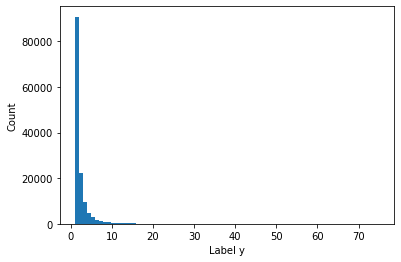

<IPython.core.display.Javascript object>

In [5]:
plt.hist(word_meaning_train_data["y"], bins=word_meaning_train_data["y"].max())
plt.xlabel("Label y")
plt.ylabel("Count")
plt.show()

In [6]:
print("Test")
word_meaning_test_data

Test


,word,y,X_tps_10,X_tps_10_pd_max,X_tps_10_pd_avg,X_tps_10_pd_std,X_tps_20,X_tps_20_pd_max,X_tps_20_pd_avg,X_tps_20_pd_std,...,X_gad_knn_200_1250_P_int,X_gad_knn_200_1500_P_bnd,X_gad_knn_200_1500_P_man,X_gad_knn_200_1500_P_int,X_gad_knn_200_1750_P_bnd,X_gad_knn_200_1750_P_man,X_gad_knn_200_1750_P_int,X_gad_knn_200_2000_P_bnd,X_gad_knn_200_2000_P_man,X_gad_knn_200_2000_P_int
0,millinery,2,4.113964,1.025418,0.914214,0.074536,7.941398,1.005300,0.835937,0.109570,...,0,0,0,0,0,0,0,0,0,0
1,delegates,3,4.421070,1.123658,0.982460,0.090000,8.802174,1.097448,0.926545,0.124209,...,0,1,0,0,1,0,0,1,0,0
2,mutely,1,3.997394,0.958832,0.888310,0.042170,8.076848,0.976295,0.850195,0.060368,...,0,0,0,0,0,0,0,0,0,0
3,overseas,4,4.709002,1.157293,1.046445,0.078913,9.061800,1.103109,0.953874,0.083135,...,0,1,0,0,1,0,0,1,0,0
4,lanceolate_leaves,1,4.229253,0.994342,0.939834,0.043271,8.449794,1.006421,0.889452,0.065294,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7211,verbal_noun,1,3.631712,0.895475,0.807047,0.060252,7.756122,1.009369,0.816434,0.080999,...,0,0,0,0,0,0,0,0,0,0
7212,greenwings,1,3.963176,1.029086,0.880706,0.078426,7.775979,0.955795,0.818524,0.078575,...,0,1,0,0,1,0,0,1,0,0
7213,azeris,1,4.511842,1.135311,1.002632,0.090496,8.474615,1.049158,0.892065,0.095074,...,0,0,0,0,0,0,0,0,0,0
7214,northwester,3,3.716126,0.856231,0.825806,0.025421,7.629259,0.892538,0.803080,0.037137,...,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

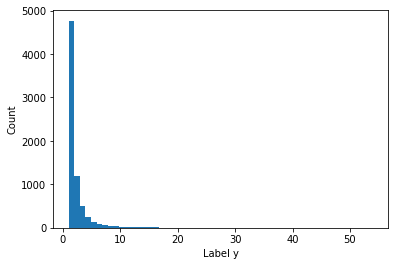

<IPython.core.display.Javascript object>

In [7]:
plt.hist(word_meaning_test_data["y"], bins=word_meaning_test_data["y"].max())
plt.xlabel("Label y")
plt.ylabel("Count")
plt.show()

In [8]:
# Split into X and y
X_train = minmax_scale(word_meaning_train_data[word_meaning_data_feature_cols].values)
X_test = minmax_scale(word_meaning_test_data[word_meaning_data_feature_cols].values)
X_test_semeval = minmax_scale(
    word_meaning_semeval_test_data[word_meaning_data_feature_cols].values
)
y_train = word_meaning_train_data["y"].values
y_test = word_meaning_test_data["y"].values
y_test_semeval = word_meaning_semeval_test_data["y"].values

<IPython.core.display.Javascript object>

In [9]:
# Create multi-class labels
max_y_multi = np.quantile(y_train, q=0.9)
y_train_binary_classes = create_classification_labels(labels=y_train, max_label=1)
y_train_multi_class = create_classification_labels(
    labels=y_train, max_label=max_y_multi
)
y_test_binary_classes = create_classification_labels(labels=y_test, max_label=1)
y_test_multi_class = create_classification_labels(labels=y_test, max_label=max_y_multi)
y_test_semeval_binary_classes = create_classification_labels(
    labels=y_test_semeval, max_label=1
)
y_test_semeval_multi_class = create_classification_labels(
    labels=y_test_semeval, max_label=max_y_multi
)
labels_str = [
    str(label + 1) if i < 4 else "gt_or_eq_5"
    for i, label in enumerate(np.unique(y_train_multi_class))
]

<IPython.core.display.Javascript object>

In [10]:
# Load output from training word2vec
w2v_training_output = load_model_training_output(
    model_training_output_dir=join(
        word2vec_training_dir, "word2vec_enwiki_jan_2021_word2phrase"
    ),
    model_name="word2vec",
    dataset_name="enwiki",
    return_normalized_embeddings=True,
)
last_embedding_weights_normalized = w2v_training_output[
    "last_embedding_weights_normalized"
]
words = w2v_training_output["words"]
word_to_int = w2v_training_output["word_to_int"]
word_counts = w2v_training_output["word_counts"]

<IPython.core.display.Javascript object>

In [11]:
# Load SemEval-2010 task 14 words
semeval_2010_14_word_senses = joblib.load(
    join(
        "..", "topological_data_analysis", "data", "semeval_2010_14_word_senses.joblib"
    )
)
semeval_target_words = np.array(list(semeval_2010_14_word_senses["all"].keys()))
semeval_target_words_in_vocab_filter = [
    i for i, word in enumerate(semeval_target_words) if word in word_to_int
]
semeval_target_words_in_vocab = semeval_target_words[
    semeval_target_words_in_vocab_filter
]
semeval_gs_clusters = np.array(list(semeval_2010_14_word_senses["all"].values()))
semeval_gs_clusters_in_vocab = semeval_gs_clusters[semeval_target_words_in_vocab_filter]

num_semeval_words = len(semeval_target_words_in_vocab)

<IPython.core.display.Javascript object>

## Evaluate modeling results

In [12]:
# Constants
estimate_num_meanings_supervised_dir = join("data", "estimate_num_meanings_supervised")

<IPython.core.display.Javascript object>

### LASSO / Logistic regression

In [22]:
# Load results
lasso_reg = joblib.load(join(estimate_num_meanings_supervised_dir, "lasso_reg.joblib"))
binary_logistic_reg = joblib.load(
    join(estimate_num_meanings_supervised_dir, "binary_logistic_reg.joblib")
)
multi_class_logistic_reg = joblib.load(
    join(estimate_num_meanings_supervised_dir, "multi_class_logistic_reg.joblib")
)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LogisticRegressionCV from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


<IPython.core.display.Javascript object>

#### LASSO

In [23]:
print(f"Selected alpha: {lasso_reg.alpha_}")

Selected alpha: 1e-06


<IPython.core.display.Javascript object>

In [24]:
visualize_feature_importances(
    feature_importances=create_feature_importance_df(
        feature_names=word_meaning_data_feature_cols,
        feature_importances=np.abs(lasso_reg.coef_),
    )
)

,feature,importance
0,X_tps_250_pd_avg,213.17457903827173
1,X_tps_250,169.21529522038938
2,X_tps_240,28.75612264245245
3,X_estimated_id_mle_200,22.02098610934721
4,X_estimated_id_mle_150,17.96401145396729
5,X_estimated_id_tle_150,12.310519424929073
6,X_tps_250_pd_std,12.058409471962062
7,X_tps_230,8.685182371858978
8,X_estimated_id_tle_200,7.999190330514358
9,X_tps_220,7.812835984216176


<IPython.core.display.Javascript object>

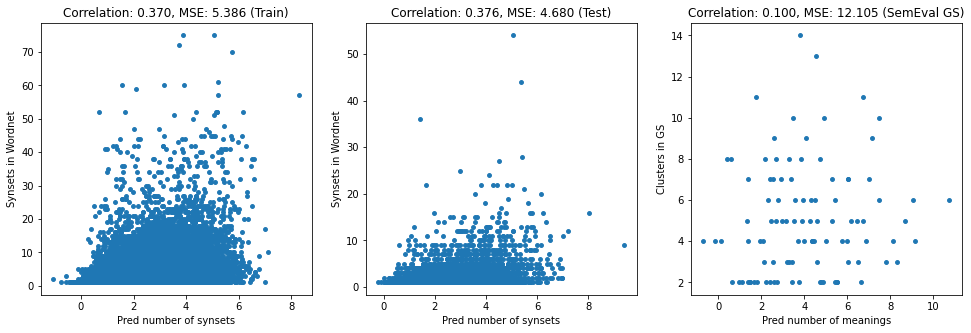

<IPython.core.display.Javascript object>

In [25]:
# LASSO regression
evaluate_regression_model(
    model=lasso_reg,
    test_sets=[
        (X_train, y_train, "Train", "Pred number of synsets", "Synsets in Wordnet"),
        (X_test, y_test, "Test", "Pred number of synsets", "Synsets in Wordnet"),
        (
            X_test_semeval,
            y_test_semeval,
            "SemEval GS",
            "Pred number of meanings",
            "Clusters in GS",
        ),
    ],
)

#### Logistic regression with L1 penalty

In [26]:
print(f"Selected alpha: {(1 / binary_logistic_reg.C_)[0]}")

Selected alpha: 0.02966297333033304


<IPython.core.display.Javascript object>

In [18]:
visualize_feature_importances(
    feature_importances=create_feature_importance_df(
        feature_names=word_meaning_data_feature_cols,
        feature_importances=np.abs(binary_logistic_reg.coef_[0]),
    )
)

,feature,importance
0,X_tps_250_pd_avg,65.25968183432758
1,X_tps_250,45.030410383247784
2,X_tps_250_pd_std,12.410131456333328
3,X_tps_240_pd_avg,9.403092651253184
4,X_tps_240,9.403092651226656
5,X_estimated_id_tle_200,8.865462385834784
6,X_tps_240_pd_std,7.080155199149527
7,X_estimated_id_mle_150,6.255347826450619
8,X_estimated_id_mle_100,5.5279068103151525
9,X_tps_220_pd_avg,5.332701203426663


<IPython.core.display.Javascript object>

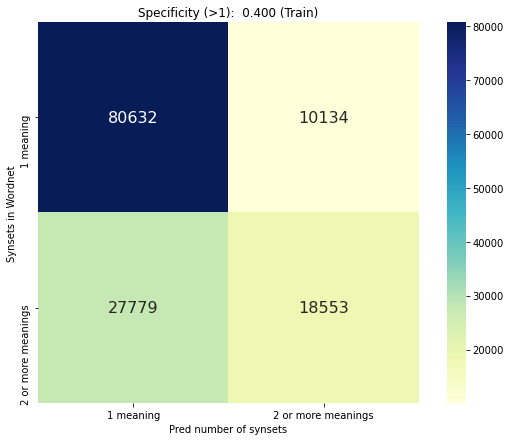

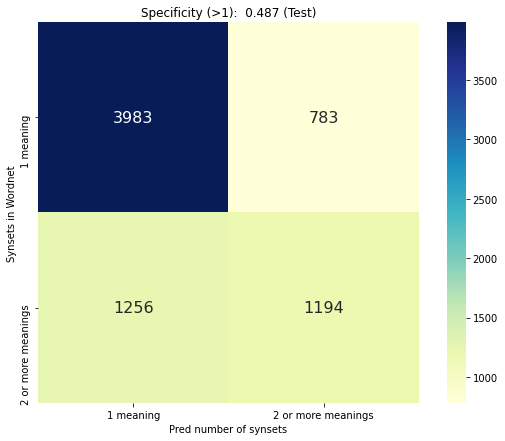

<IPython.core.display.Javascript object>

In [19]:
# Binary classification
evaluate_classification_model(
    model=binary_logistic_reg,
    test_sets=[
        (
            X_train,
            y_train_binary_classes,
            "Train",
            "Pred number of synsets",
            "Synsets in Wordnet",
        ),
        (
            X_test,
            y_test_binary_classes,
            "Test",
            "Pred number of synsets",
            "Synsets in Wordnet",
        ),
    ],
    cm_ticklabels=["1 meaning", "2 or more meanings"],
)

#### Multinomial logistic regression with L1 penalty

In [20]:
alphas = 1 / multi_class_logistic_reg.C_
print(f"Selected alphas: {alphas}")

Selected alphas: [0.08127813 0.08127813 0.08127813 0.08127813 0.08127813]


<IPython.core.display.Javascript object>

In [21]:
df_dict = {}
for label_str, coeffs in zip(labels_str, multi_class_logistic_reg.coef_):
    sorted_feature_weights_indices = np.argsort(np.abs(coeffs))[::-1]
    df_dict[f"feature_{label_str}"] = word_meaning_data_feature_cols[
        sorted_feature_weights_indices
    ]
    df_dict[f"weight_{label_str}"] = coeffs[sorted_feature_weights_indices]

sorted_features_df = pd.DataFrame(df_dict)
visualize_feature_importances(feature_importances=sorted_features_df)

,feature_1,weight_1,feature_2,weight_2,feature_3,weight_3,feature_4,weight_4,feature_gt_or_eq_5,weight_gt_or_eq_5
0,X_tps_90,5.483908,X_tps_100,2.185979e+00,X_tps_70,-2.582598,X_tps_50,3.058629,X_tps_60,-3.016208
1,X_estimated_id_mle,-3.064712,X_tps_90,1.452512e+00,X_tps_60,1.893363,X_tps_70,-2.250088,X_estimated_id_twonn,-2.661173
2,X_estimated_id_twonn,1.824396,X_tps_80,-1.269355e+00,X_tps_80,1.518900,X_tps_60,-2.213706,X_tps_40,1.521031
3,X_tps_40,-1.664799,X_tps_40,-1.092723e+00,X_tps_50,-0.773635,X_estimated_id_twonn,-0.950775,X_tps_90,-1.236191
4,X_estimated_id_lpca,-1.562936,X_estimated_id_twonn,1.064382e+00,X_tps_20,0.698459,X_tps_80,0.908643,X_tps_30,0.971987
5,X_tps_70,1.466333,X_estimated_id_mle,-8.276505e-01,X_tps_90,-0.543088,X_tps_30,-0.747436,X_tps_50,0.873222
6,X_tps_80,-1.035988,X_gad_knn_25_500_P_man,7.751104e-01,X_tps_30,-0.542539,X_estimated_id_mle,0.509994,X_estimated_id_mle,0.738282
7,X_tps_100,0.960664,X_gad_knn_25_250_P_man,7.751104e-01,X_tps_40,0.453907,X_tps_40_pd_std,0.363469,X_tps_100,-0.684237
8,X_tps_20,-0.596228,X_estimated_id_lpca,-7.556746e-01,X_tps_80_pd_avg,-0.244154,X_tps_40_pd_avg,0.363469,X_estimated_id_lpca,0.636306
9,X_tps_10,-0.443040,X_tps_30,6.174733e-01,X_tps_80_pd_std,-0.244154,X_tps_40_pd_max,0.363469,X_tps_10_pd_avg,0.422329


<IPython.core.display.Javascript object>

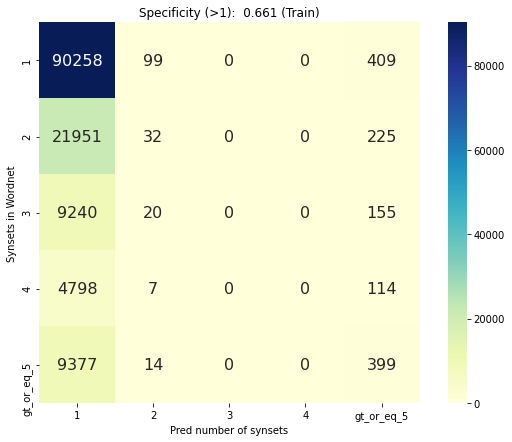

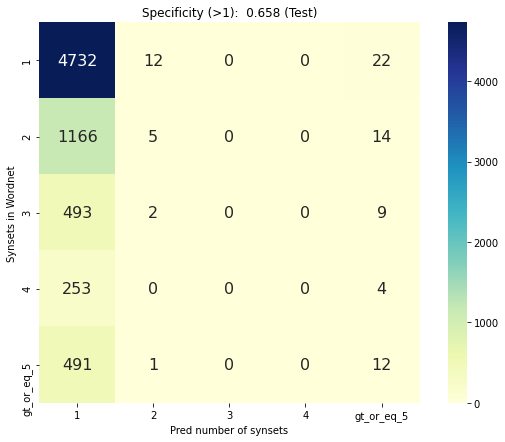

<IPython.core.display.Javascript object>

In [22]:
# Multi classification
evaluate_classification_model(
    model=multi_class_logistic_reg,
    test_sets=[
        (
            X_train,
            y_train_multi_class,
            "Train",
            "Pred number of synsets",
            "Synsets in Wordnet",
        ),
        (
            X_test,
            y_test_multi_class,
            "Test",
            "Pred number of synsets",
            "Synsets in Wordnet",
        ),
    ],
    cm_ticklabels=labels_str,
)

### XGBoost regression and classification

In [13]:
# Load results
xgb_reg = joblib.load(join(estimate_num_meanings_supervised_dir, "xgb_reg.joblib"))
xgb_reg_model = xgb_reg.best_estimator_
xgb_binary_classification = joblib.load(
    join(estimate_num_meanings_supervised_dir, "xgb_binary_classification.joblib")
)
xgb_binary_classification_model = xgb_binary_classification.best_estimator_
# xgb_multi_classification = joblib.load(join(estimate_num_meanings_supervised_dir, "xgb_multi_classification.joblib"))
# xgb_multi_classification_model = xgb_multi_classification.best_estimator_

<IPython.core.display.Javascript object>

#### XGBoost regression

array([[<AxesSubplot:xlabel='alpha', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='colsample_bytree'>,
        <AxesSubplot:xlabel='colsample_bytree', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='eta'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='eta', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='gamma'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='gamma', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='max_depth'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>,
        <AxesSubplot:xlabel='max_depth', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='alpha', ylabel='subsample'>,
        <AxesSubplot:xlabel='col

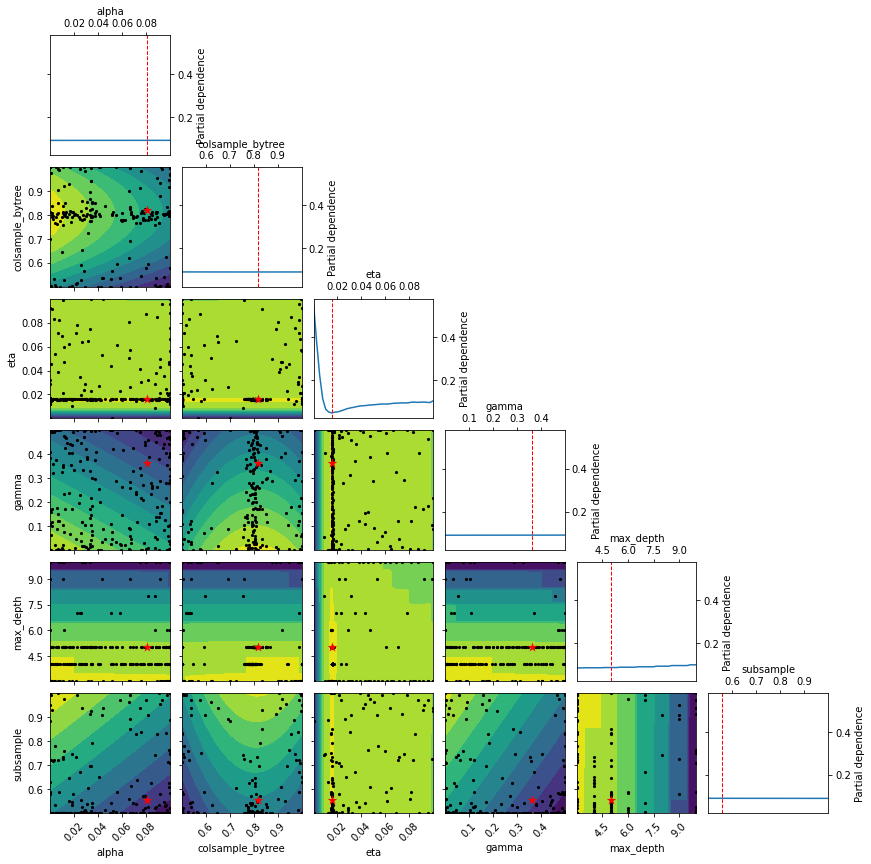

<IPython.core.display.Javascript object>

In [24]:
# Visualize bayesian optimization results
plot_objective(xgb_reg.optimizer_results_[0])

In [25]:
visualize_feature_importances(
    feature_importances=create_feature_importance_df(
        feature_names=word_meaning_data_feature_cols,
        feature_importances=xgb_reg_model.feature_importances_,
    )
)

,feature,importance
0,X_estimated_id_twonn,0.06617479
1,X_tps_10_pd_std,0.05379133
2,X_tps_50_pd_std,0.045036804
3,X_tps_10_pd_max,0.040358797
4,X_tps_100,0.038841266
5,X_tps_10_pd_avg,0.037367128
6,X_tps_60_pd_std,0.030013021
7,X_tps_90,0.028683284
8,X_tps_70_pd_avg,0.02781725
9,X_tps_20_pd_avg,0.024210995


<IPython.core.display.Javascript object>

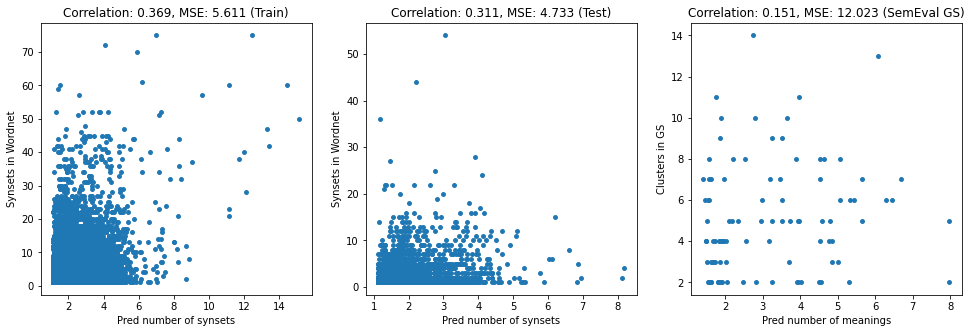

<IPython.core.display.Javascript object>

In [26]:
evaluate_regression_model(
    model=xgb_reg_model,
    test_sets=[
        (X_train, y_train, "Train", "Pred number of synsets", "Synsets in Wordnet"),
        (X_test, y_test, "Test", "Pred number of synsets", "Synsets in Wordnet"),
        (
            X_test_semeval,
            y_test_semeval,
            "SemEval GS",
            "Pred number of meanings",
            "Clusters in GS",
        ),
    ],
)

#### XGBoost binary classification

array([[<AxesSubplot:xlabel='alpha', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='colsample_bytree'>,
        <AxesSubplot:xlabel='colsample_bytree', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='eta'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='eta', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='gamma'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='gamma', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='max_depth'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>,
        <AxesSubplot:xlabel='max_depth', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
  

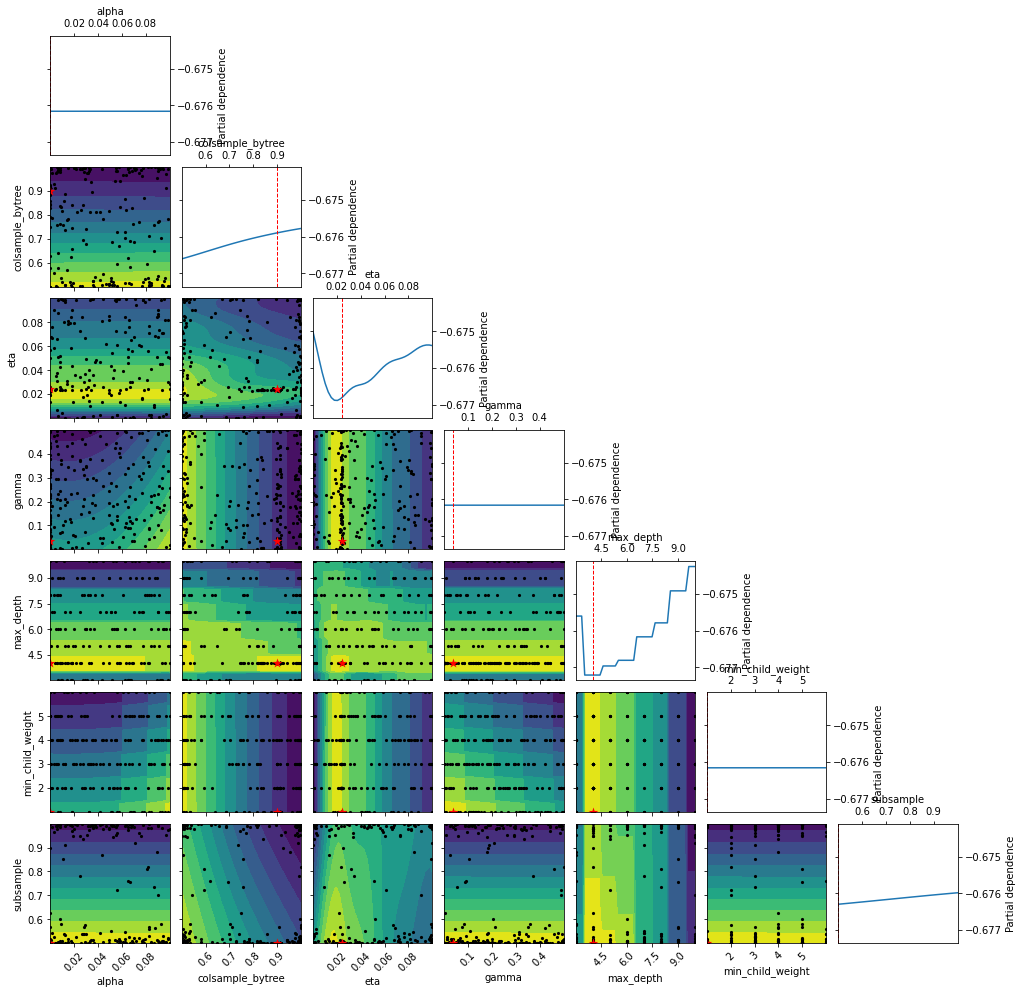

<IPython.core.display.Javascript object>

In [27]:
# Visualize bayesian optimization results
plot_objective(xgb_binary_classification.optimizer_results_[0])

In [14]:
visualize_feature_importances(
    feature_importances=create_feature_importance_df(
        feature_names=word_meaning_data_feature_cols,
        feature_importances=xgb_binary_classification_model.feature_importances_,
    )
)

,feature,importance
0,X_tps_100,0.115842216
1,X_estimated_id_twonn,0.05398016
2,X_tps_90,0.049275037
3,X_tps_10_pd_max,0.04827711
4,X_estimated_id_mle,0.042352155
5,X_gad_knn_100_1000_P_man,0.041466188
6,X_gad_knn_100_1000_P_int,0.037241217
7,X_tps_80,0.034649055
8,X_gad_knn_100_1000_P_bnd,0.0325772
9,X_tps_70,0.03253415


<IPython.core.display.Javascript object>

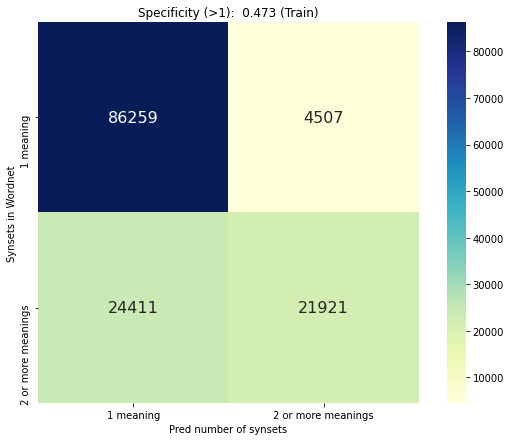

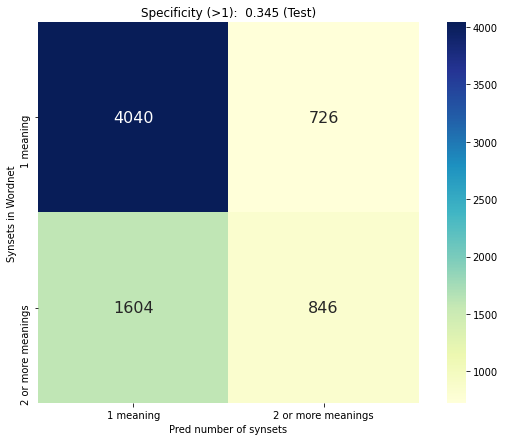

<IPython.core.display.Javascript object>

In [15]:
# Binary classification
evaluate_classification_model(
    model=xgb_binary_classification_model,
    test_sets=[
        (
            X_train,
            y_train_binary_classes,
            "Train",
            "Pred number of synsets",
            "Synsets in Wordnet",
        ),
        (
            X_test,
            y_test_binary_classes,
            "Test",
            "Pred number of synsets",
            "Synsets in Wordnet",
        ),
    ],
    cm_ticklabels=["1 meaning", "2 or more meanings"],
)

#### XGBoost multiclassification

In [ ]:
# Visualize bayesian optimization results
plot_objective(xgb_multi_classification.optimizer_results_[0])

In [ ]:
visualize_feature_importances(
    feature_importances=create_feature_importance_df(
        feature_names=word_meaning_data_feature_cols,
        feature_importances=xgb_multi_classification_model.feature_importances_,
    )
)


In [ ]:
# Multi classification
evaluate_classification_model(
    model=xgb_multi_classification_model,
    test_sets=[
        (
            X_train,
            y_train_multi_class,
            "Train",
            "Pred number of synsets",
            "Synsets in Wordnet",
        ),
        (
            X_test,
            y_test_multi_class,
            "Test",
            "Pred number of synsets",
            "Synsets in Wordnet",
        ),
    ],
    cm_ticklabels=labels_str,
)